# Analysis of OSM tags

This notebook contains an explorative analysis of the distribution of existing and missing tag information in OSM tag based on the grid with aggregated OSM data.

The notebook requires input data from running BikeDNA BIG and from running the notebook `prepare_population_grid.ipynb` in this repository.

Results are saved to subfolders in the `results/osm_analysis/[study_area]/` folder.

**Content:**

* [Spatial patterns in existing tags](#spatial-patterns-in-existing-tags)
* [Correlations between missing tags](#correlations-between-missing-tags)
* [Correlation between missing tags and population density](#correlation-between-missing-tags--population-density)

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pickle
import json
import pandas as pd
import seaborn as sns
import plotly.express as px
import pandas as pd
from pysal.explore import esda
from pysal.lib import weights
from splot.esda import lisa_cluster

from src import evaluation_functions as eval_func

%run ../settings/yaml_variables.py
%run ../settings/df_styler.py
%run ../settings/plotting.py
%run ../settings/load_osmdata.py
%run ../settings/paths.py

/opt/miniconda3/envs/bikedna_analysis/lib/python3.11/site-packages/pysal/explore/segregation/network/network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
/opt/miniconda3/envs/bikedna_analysis/lib/python3.11/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


OSM data loaded successfully!


In [36]:
total_count = len(osm_edges)

count_edges_with_lit = len(osm_edges.loc[osm_edges.lit.notna()])
count_edges_with_speed = len(osm_edges.loc[osm_edges.maxspeed.notna()])

count_edges_with_surface_centerline = len(
    osm_edges.loc[
        (osm_edges.cycleway_surface.notna())
        & (osm_edges.bicycle_geometries == "centerline")
    ]
)

count_edges_with_surface_true_geoms = len(
    osm_edges.loc[
        (osm_edges.cycleway_surface.notna() | osm_edges.surface.notna())
        & (osm_edges.bicycle_geometries == "true_geometries")
    ]
)

count_edges_with_width_centerline = len(
    osm_edges.loc[
        
            osm_edges.cycleway_width.notna()
        
        & (osm_edges.bicycle_geometries == "centerline")
    ]
)

count_edges_with_surface_true_geoms = len(
    osm_edges.loc[
        (
            osm_edges.width.notna()
            | osm_edges.cycleway_width.notna()
        )
        & (osm_edges.bicycle_geometries == "true_geometries")
    ]
)

pct_edges_with_lit = count_edges_with_lit / total_count * 100
pct_edges_with_speed = count_edges_with_speed / total_count * 100
pct_edges_with_surface = (
    (count_edges_with_surface_centerline + count_edges_with_surface_true_geoms)
    / total_count
    * 100
)
pct_edges_with_width = (
    (count_edges_with_width_centerline + count_edges_with_surface_true_geoms)
    / total_count
    * 100
)

print(
    f"{count_edges_with_lit} osm edges, or {pct_edges_with_lit:.2f}% have data on 'lit'"
)
print(
    f"{count_edges_with_surface_centerline + count_edges_with_surface_true_geoms} osm edges, or {pct_edges_with_surface:.2f}% have data on 'surface'"
)
print(
    f"{count_edges_with_speed} osm edges, or {pct_edges_with_speed:.2f}% have data on 'maxspeed'"
)
print(
    f"{count_edges_with_width_centerline+count_edges_with_surface_true_geoms} osm edges, or {pct_edges_with_width:.2f}% have data on 'width'"
)

194829 osm edges, or 40.39% have data on 'lit'
16327 osm edges, or 3.39% have data on 'surface'
129443 osm edges, or 26.84% have data on 'maxspeed'
16537 osm edges, or 3.43% have data on 'width'


In [2]:
# Read intrinsic grid results
with open(
    f"../results/OSM/{study_area}/data/grid_results_intrinsic.pickle", "rb"
) as fp:
    osm_intrinsic_grid = pickle.load(fp)

osm_intrinsic_grid.dropna(subset="count_osm_edges", inplace=True)

## Spatial patterns in existing tags

This section analyzes the spatial distribution of share of bicycle edges *with* the relevant OSM tags added.

In [3]:
variable_names = [
    "surface",
    "width",
    "speedlimit",
    "lit",
]  # Update if other tag types have been analyzed when running BikeDNA

for v in variable_names:
    rename_dict = {
        f"existing_tags_{v}_length_pct_missing": f"{v}_length_pct_missing",
        f"existing_tags_{v}_count_pct_missing": f"{v}_count_pct_missing",
        f"existing_tags_{v}_length_pct": f"{v}_length_pct",
        f"existing_tags_{v}_count_pct": f"{v}_count_pct",
    }

    osm_intrinsic_grid.rename(rename_dict, inplace=True, axis=1)

/opt/miniconda3/envs/bikedna_analysis/lib/python3.11/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 21 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


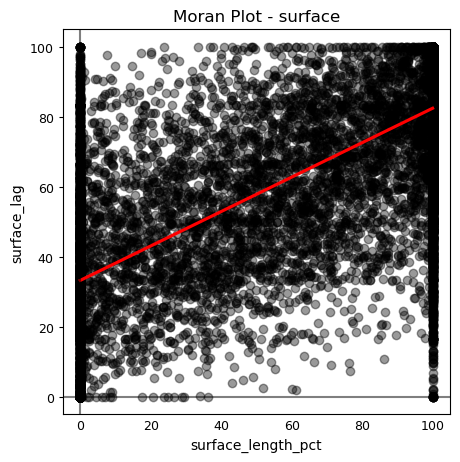

With significance 0.001, the Moran's I value for surface is 0.49


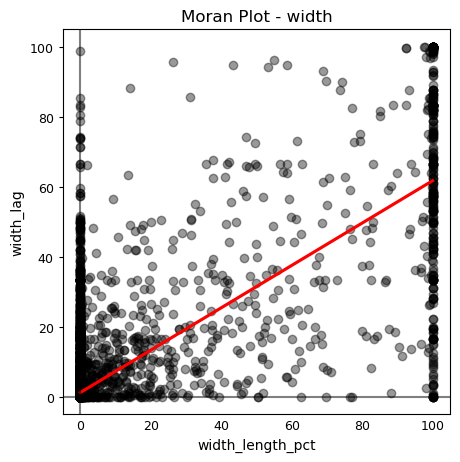

With significance 0.001, the Moran's I value for width is 0.61


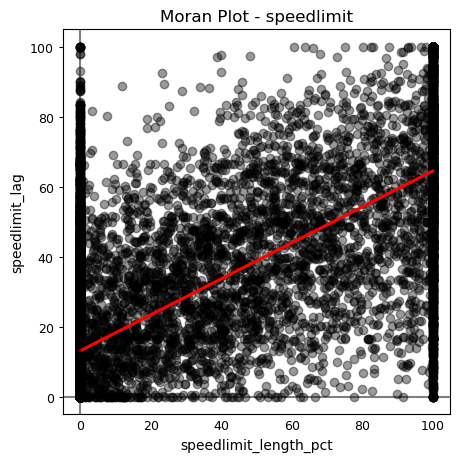

With significance 0.001, the Moran's I value for speedlimit is 0.51


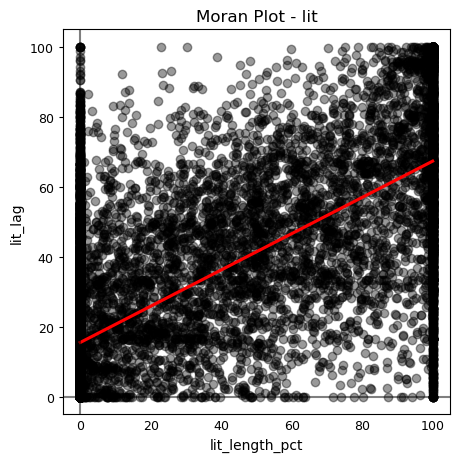

With significance 0.001, the Moran's I value for lit is 0.52


In [4]:
pct_length_existing = [f"{v}_length_pct" for v in variable_names]

col_names = pct_length_existing

filepaths = [osm_analysis_fp + f"morans_{v}_length.png" for v in variable_names]

w = eval_func.compute_spatial_weights(osm_intrinsic_grid, ["count_osm_edges"], "knn")

morans_tags = eval_func.compute_spatial_autocorrelation(
    col_names, variable_names, osm_intrinsic_grid, w, filepaths
)

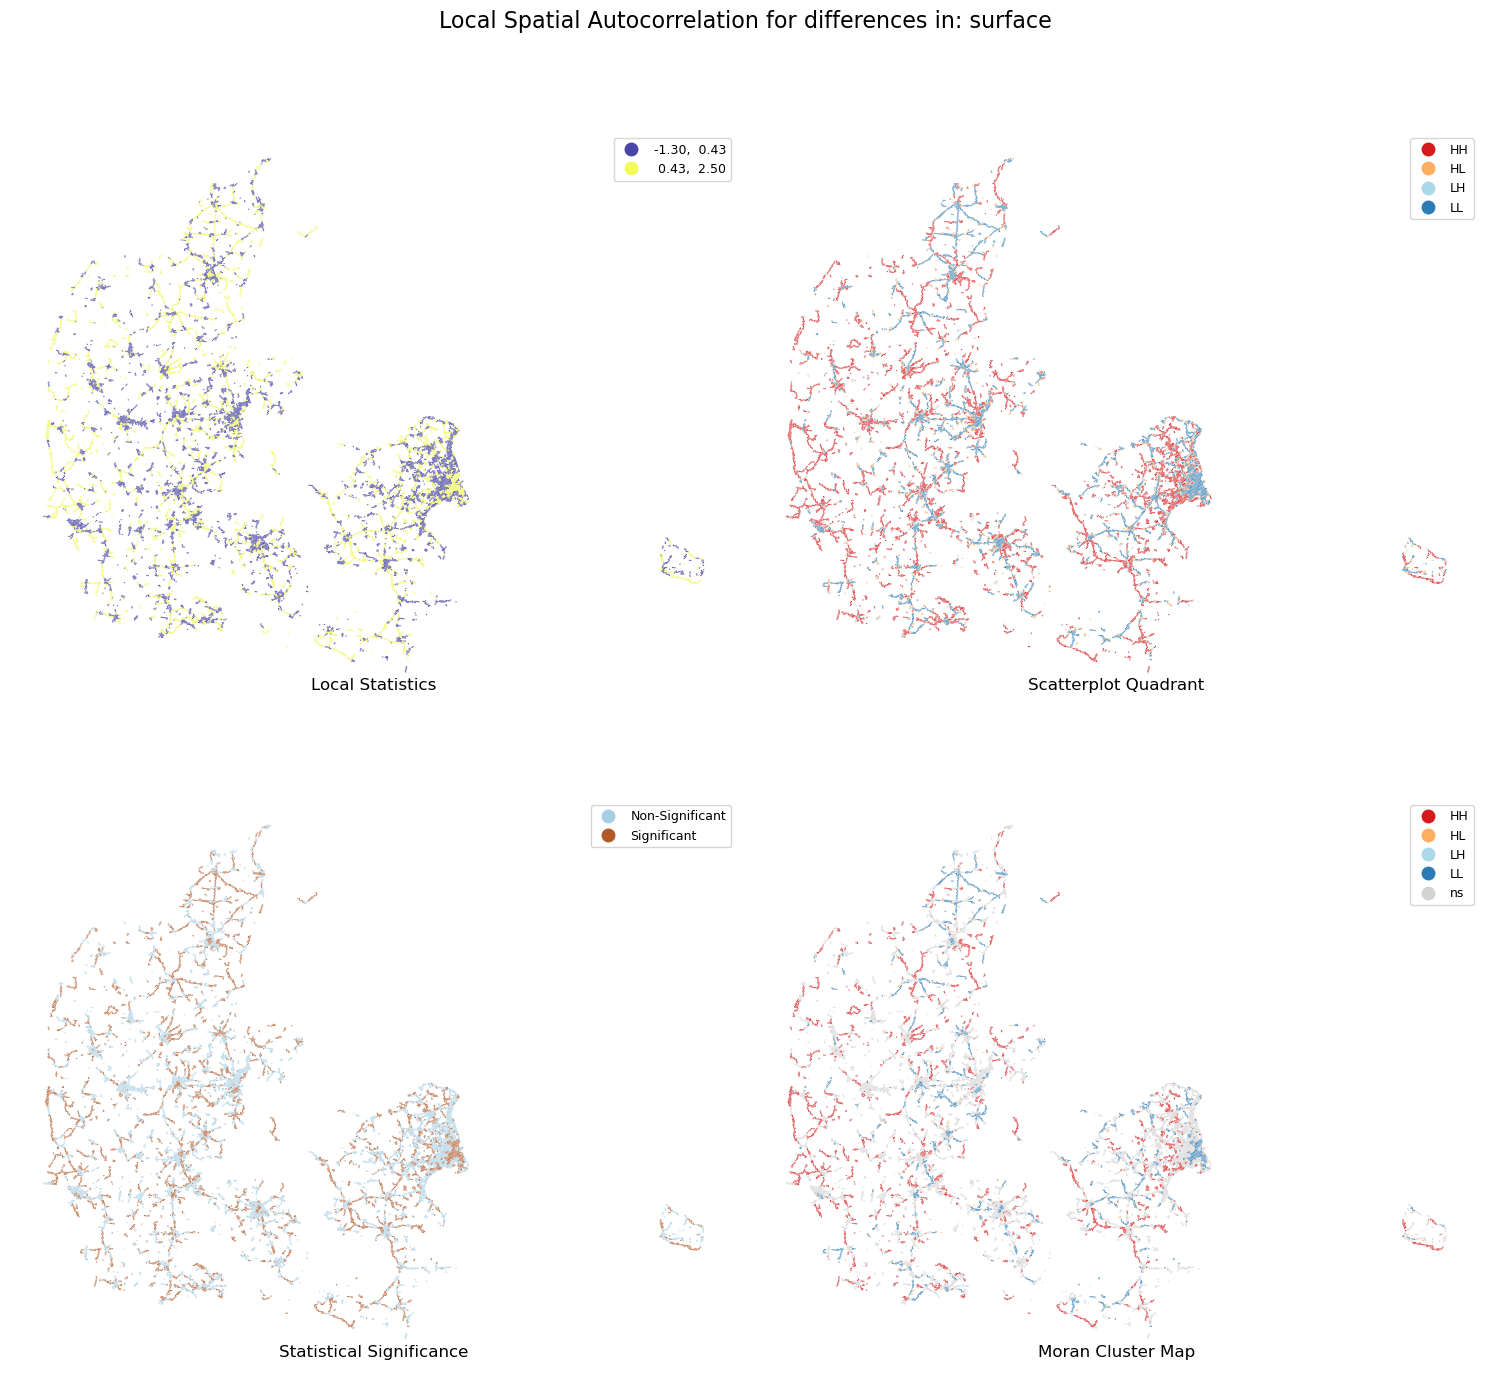

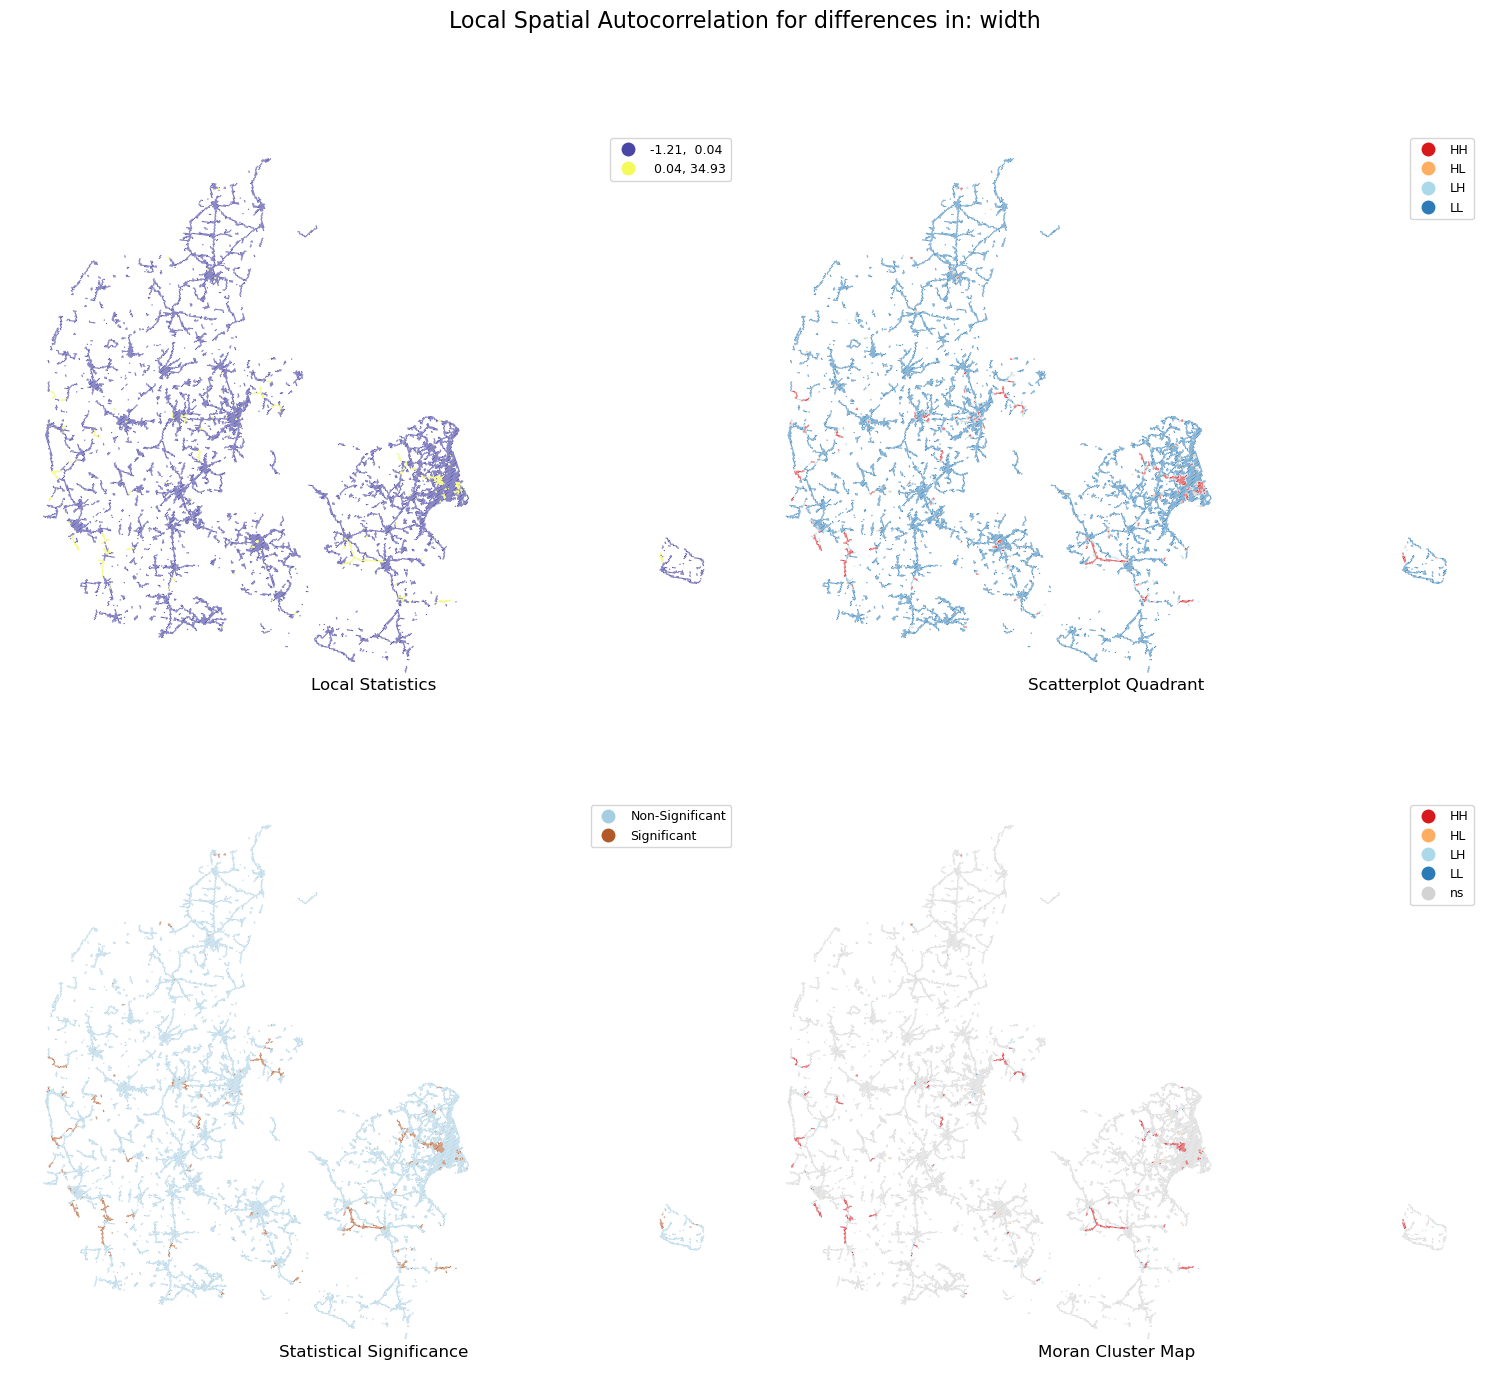

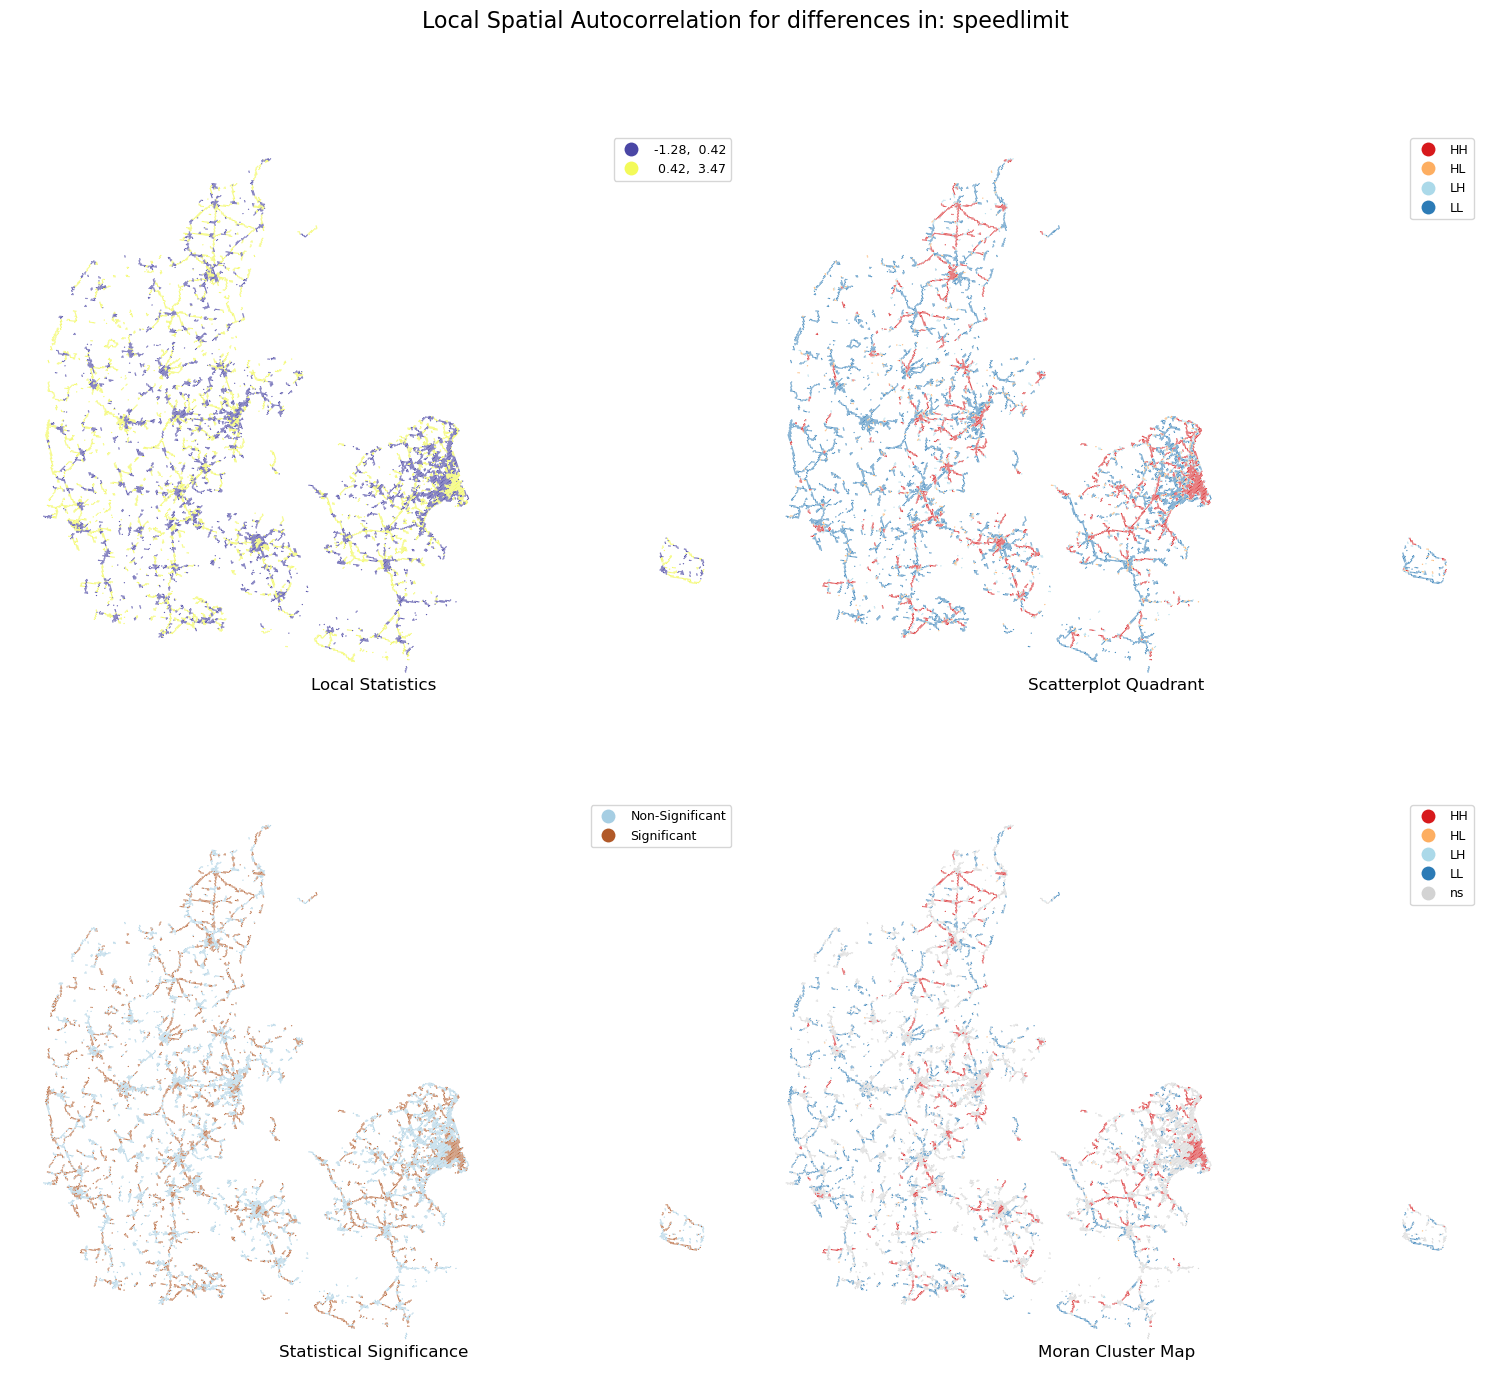

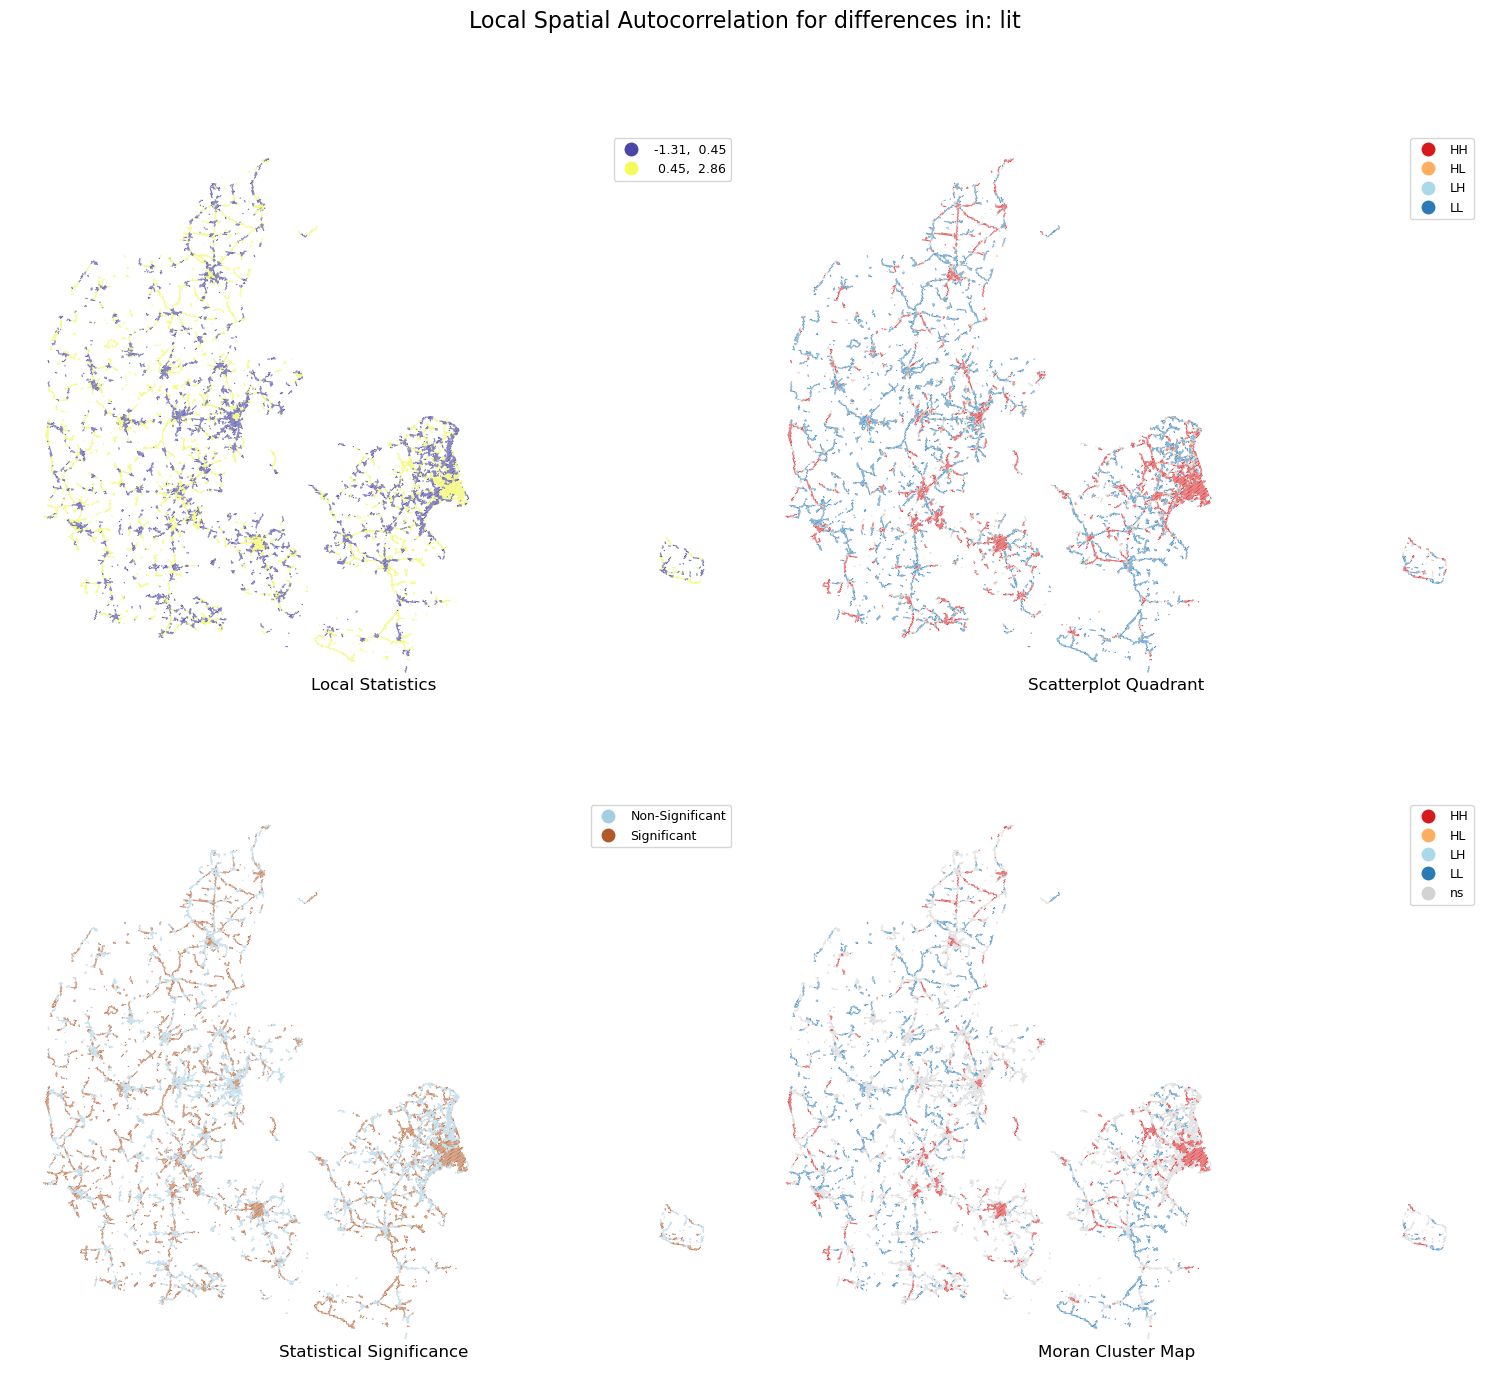

In [5]:
col_names = pct_length_existing

filepaths = [osm_analysis_fp + f"lisa_{v}_length.png" for v in variable_names]

lisas_tags = eval_func.compute_lisa(
    col_names, variable_names, osm_intrinsic_grid, w, filepaths
)

In [6]:
for v in variable_names:
    hotspot = len(osm_intrinsic_grid[osm_intrinsic_grid[f"{v}_q"] == "HH"])
    coldspot = len(osm_intrinsic_grid[osm_intrinsic_grid[f"{v}_q"] == "LL"])

    print(
        f"For the tag '{v}', {hotspot} out of {len(osm_intrinsic_grid)} grid cells ({hotspot/len(osm_intrinsic_grid)*100:.2f}%) are part of a hotspot (based on the length of edges with a given tag)."
    )
    print(
        f"For the tag '{v}', {coldspot} out of {len(osm_intrinsic_grid)} grid cells ({coldspot/len(osm_intrinsic_grid)*100:.2f}%) are part of a coldspot (based on the length of edges with a given tag)."
    )
    print("\n")

For the tag 'surface', 3524 out of 14506 grid cells (24.29%) are part of a hotspot (based on the length of edges with a given tag).
For the tag 'surface', 2396 out of 14506 grid cells (16.52%) are part of a coldspot (based on the length of edges with a given tag).


For the tag 'width', 522 out of 14506 grid cells (3.60%) are part of a hotspot (based on the length of edges with a given tag).
For the tag 'width', 6 out of 14506 grid cells (0.04%) are part of a coldspot (based on the length of edges with a given tag).


For the tag 'speedlimit', 2242 out of 14506 grid cells (15.46%) are part of a hotspot (based on the length of edges with a given tag).
For the tag 'speedlimit', 3020 out of 14506 grid cells (20.82%) are part of a coldspot (based on the length of edges with a given tag).


For the tag 'lit', 2460 out of 14506 grid cells (16.96%) are part of a hotspot (based on the length of edges with a given tag).
For the tag 'lit', 3772 out of 14506 grid cells (26.00%) are part of a cold

In [7]:
lit_hot = len(osm_intrinsic_grid.loc[osm_intrinsic_grid.lit_q == "HH"])
surface_cold = len(osm_intrinsic_grid.loc[osm_intrinsic_grid.surface_q == "LL"])
both = len(
    osm_intrinsic_grid.loc[
        (osm_intrinsic_grid.lit_q == "HH") & (osm_intrinsic_grid.surface_q == "LL")
    ]
)

print(
    f"Out of {lit_hot} cells in a lit hotspot and {surface_cold} cells in a surface cold spot, {both} cells are both in a lit hot spot and surface cold spot (based on the length of edges with a given tag)."
)

Out of 2460 cells in a lit hotspot and 2396 cells in a surface cold spot, 909 cells are both in a lit hot spot and surface cold spot (based on the length of edges with a given tag).


In [8]:
# Export
q_cols = [v + "_q" for v in variable_names]
q_cols.append("hex_id")
osm_intrinsic_grid[q_cols].to_csv(
    osm_analysis_fp + "tags_spatial_autocorrelation.csv", index=False
)

## Correlations between missing tags

The section below explores the correlation between the *share* of missing tags across the various tag types. 

The pairplots are made for both the share of the count of edges and the share of the lenght of edges without a given tag.

In both cases, a plot including all locations with OSM data is produced and a plot only showing areas with less than 100% edges missing tag information.

In [9]:
length_missing = [f"{v}_length_pct_missing" for v in variable_names]

count_missing = [f"{v}_count_pct_missing" for v in variable_names]


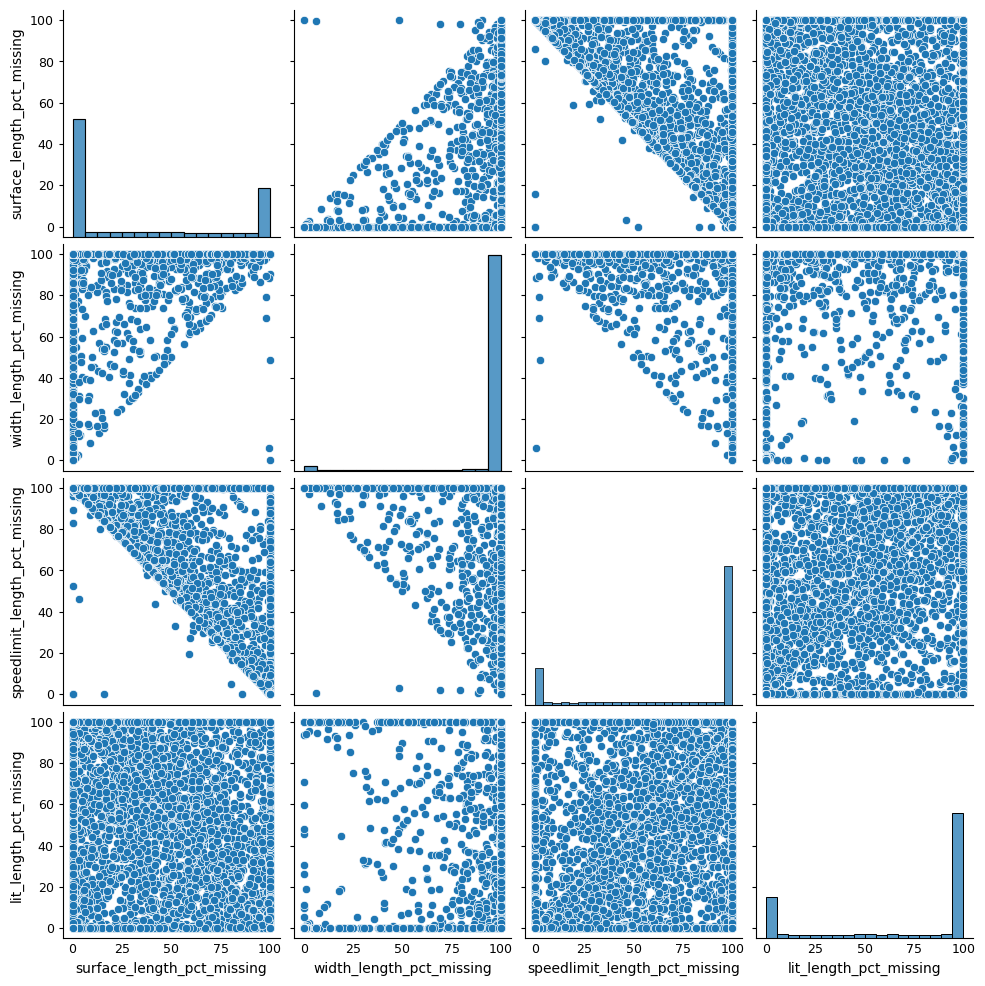

In [10]:
sns.pairplot(osm_intrinsic_grid[length_missing].dropna())
# To not have the plot cluttered by areas where ALL

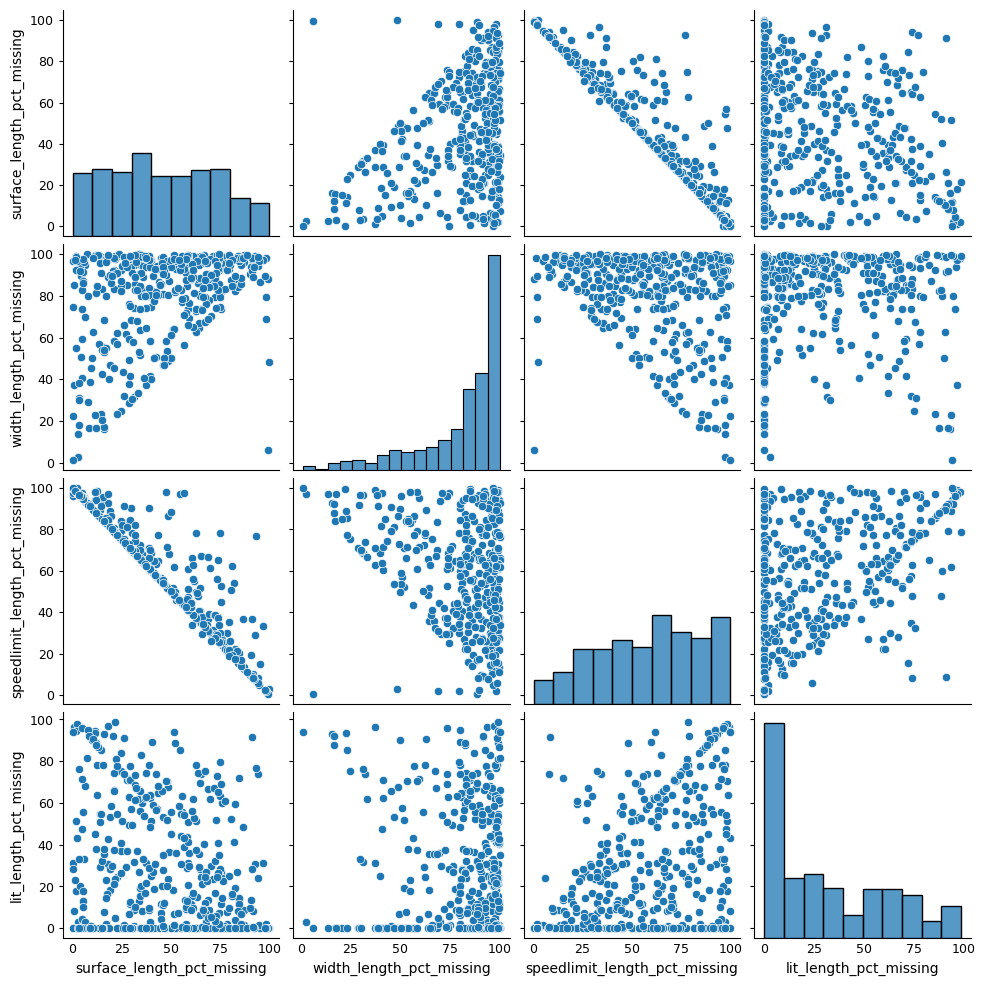

In [11]:
# To not have the plot cluttered by areas where ALL edges are missing a tag, only include those with less than 100% missing

sns.pairplot(
    osm_intrinsic_grid[osm_intrinsic_grid[length_missing] < 100][
        length_missing
    ].dropna()
)

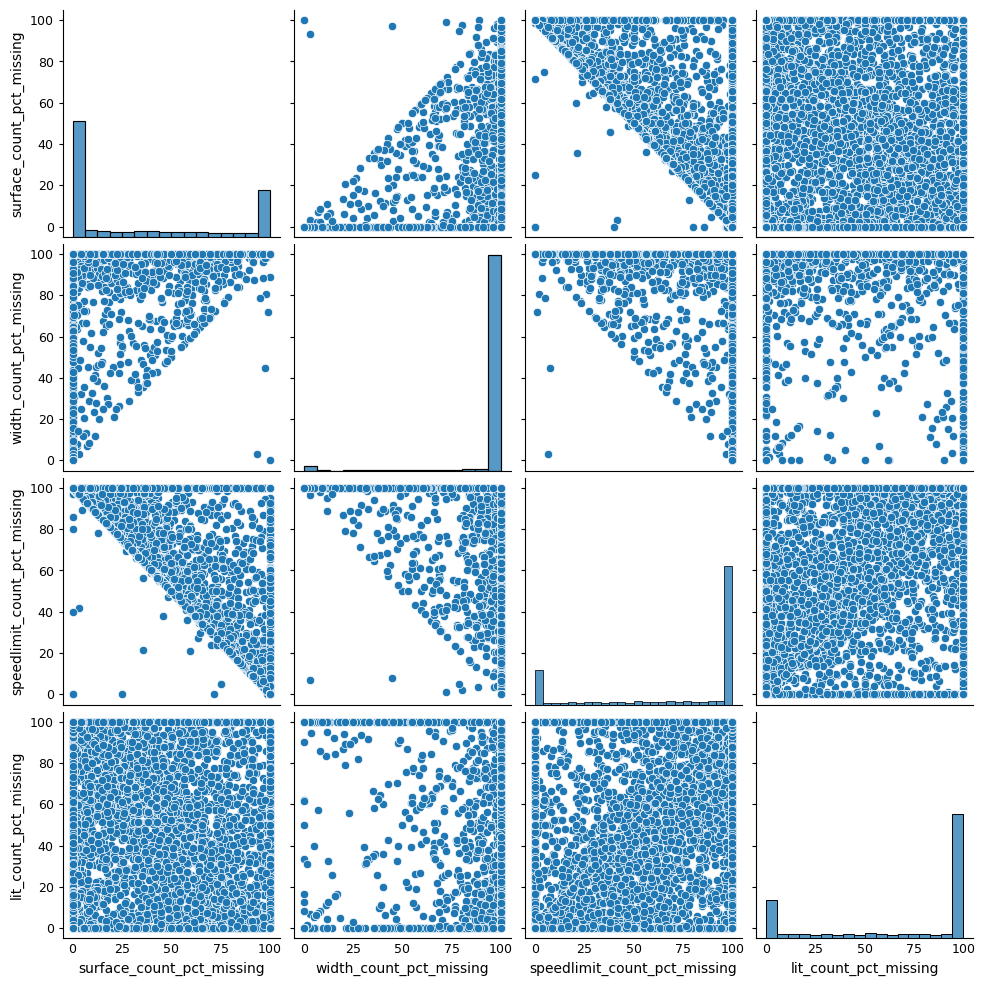

In [12]:
sns.pairplot(osm_intrinsic_grid[count_missing].dropna())

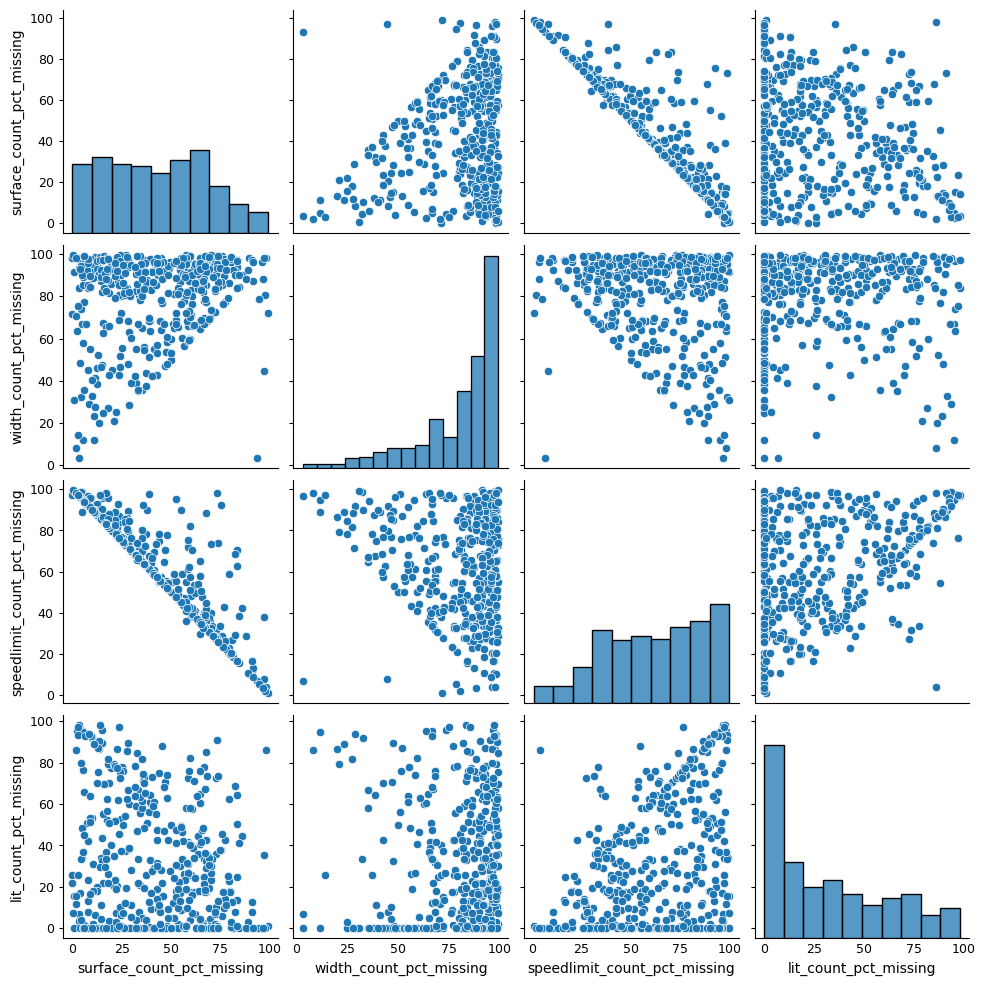

In [13]:
sns.pairplot(
    osm_intrinsic_grid[osm_intrinsic_grid[count_missing] < 100][count_missing].dropna()
)

### Visualizing correlation between selected missing tags and edge density

The plots below explore the relationship between the share of edges missing a given tag with edge density as a third variable.

OBS: Variable names are hardcoded here.

In [14]:
fig = px.scatter(
    osm_intrinsic_grid,
    x="surface_count_pct_missing",
    y="speedlimit_count_pct_missing",
    color="osm_edge_density",
    title="Correlation between missing tags",
    color_continuous_scale="viridis_r",
    labels={
        "osm_edge_density": "edge density (m/sqkm)",
        "speedlimit_count_pct_missing": "Pct edges without speedlimit tag",
        "surface_count_pct_missing": "Pct edges without surface tag",
    },
)

fig.update_layout(font=dict(size=12, color="RebeccaPurple"))
fig.show()

In [15]:
fig = px.scatter(
    osm_intrinsic_grid,
    x="surface_count_pct_missing",
    y="lit_count_pct_missing",
    color="osm_edge_density",
    title="Correlation between missing tags",
    color_continuous_scale="viridis_r",
    labels={
        "osm_edge_density": "edge density (m/sqkm)",
        "speedlimit_count_pct_missing": "Pct edges without speedlimit tag",
        "surface_count_pct_missing": "Pct edges without surface tag",
        "lit_count_pct_missing": "Pct edges without lit tag",
    },
)

fig.update_layout(font=dict(size=12, color="RebeccaPurple"))
fig.show()

## Correlation between tag completeness & population density

In the plots below we explore a simple correlation between the share of local edges/the share of the length of local edges with a given tag and the population density.

In [16]:
# Join population grid with osm grid

pop_grid = gpd.read_parquet(
    pop_processed_fp + f"h3_population_polygons_{study_area}.parquet"
)

joined_grid = osm_intrinsic_grid.merge(
    pop_grid[["hex_id", "pop_dens"]], on="hex_id", how="inner"
)

assert len(joined_grid) == len(osm_intrinsic_grid)

### Pct edges with tags (count)

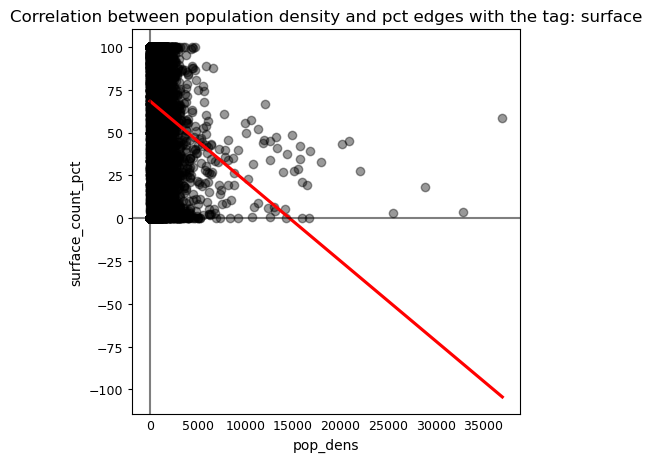

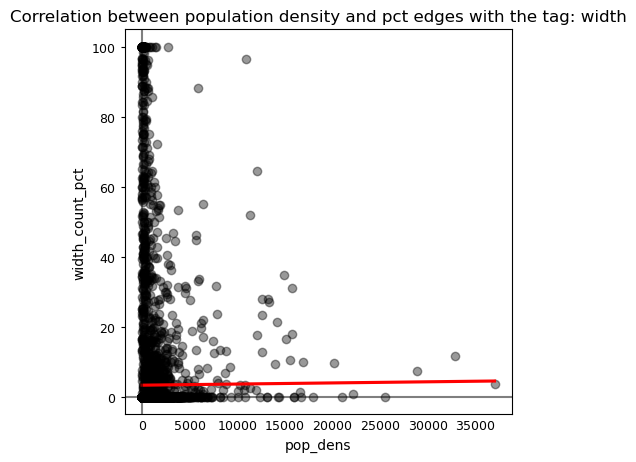

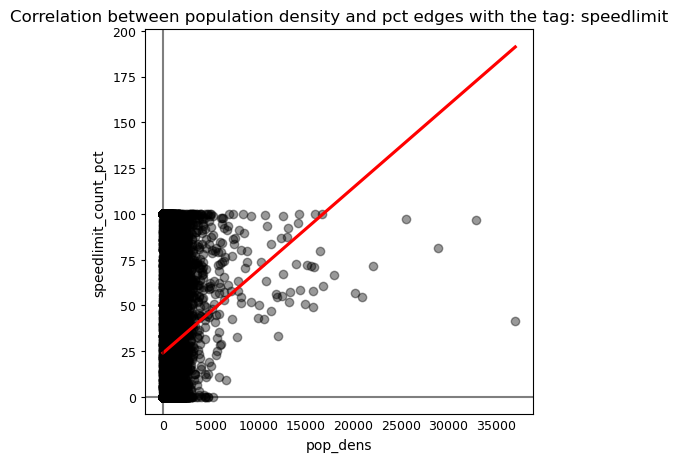

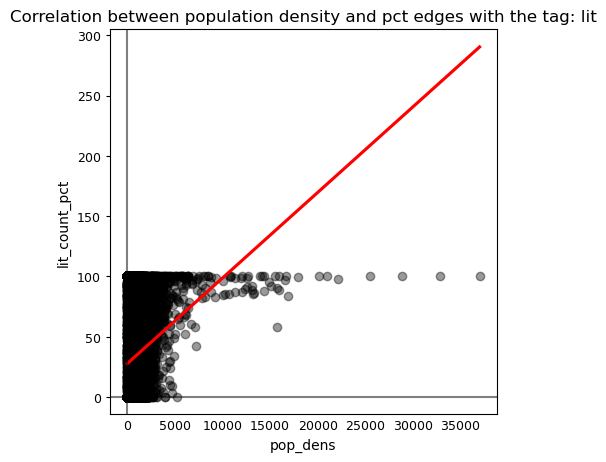

In [17]:
length_cols = [f"{v}_length_pct" for v in variable_names]


count_cols = [f"{v}_count_pct" for v in variable_names]


for i, v in enumerate(variable_names):
    f, ax = plt.subplots(1, figsize=(5, 5))

    sns.regplot(
        x="pop_dens",
        y=count_cols[i],
        ci=None,
        data=joined_grid,
        line_kws={"color": "r"},
        scatter_kws={"alpha": 0.4},
        color="black",
    )

    ax.axvline(0, c="k", alpha=0.5)
    ax.axhline(0, c="k", alpha=0.5)
    ax.set_title(
        f"Correlation between population density and pct edges with the tag: {v}"
    )
    plt.show()

### Pct edges with tags (length)

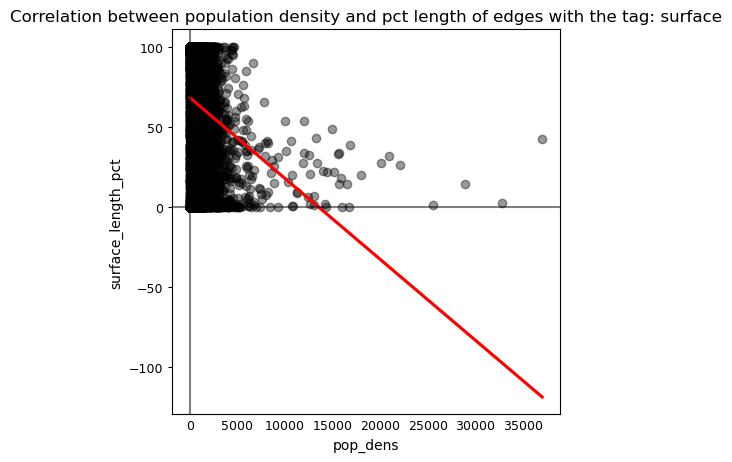

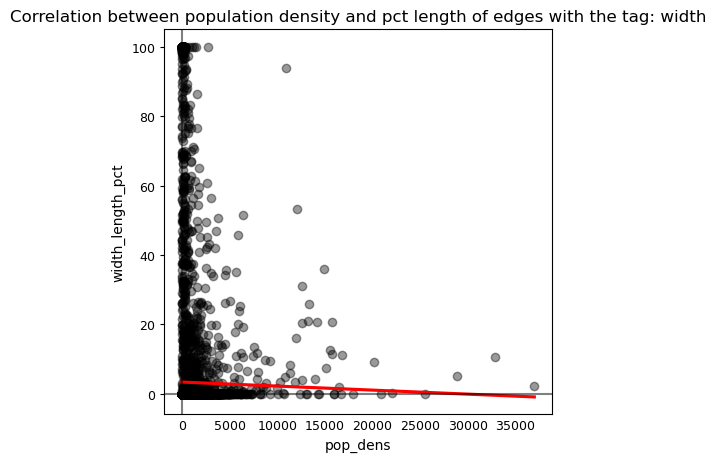

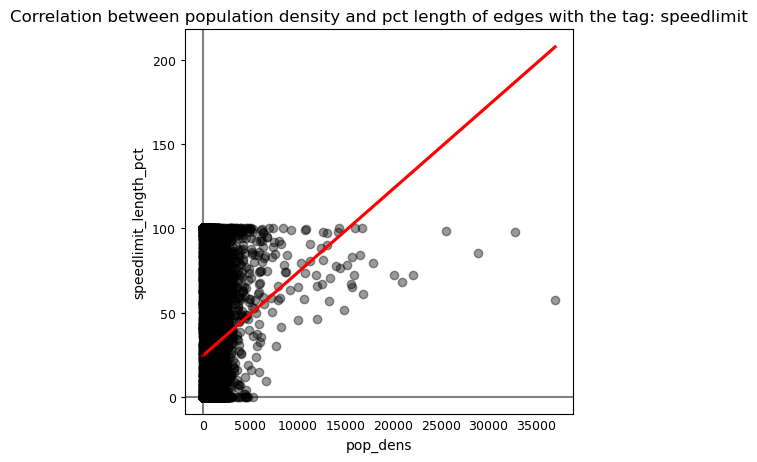

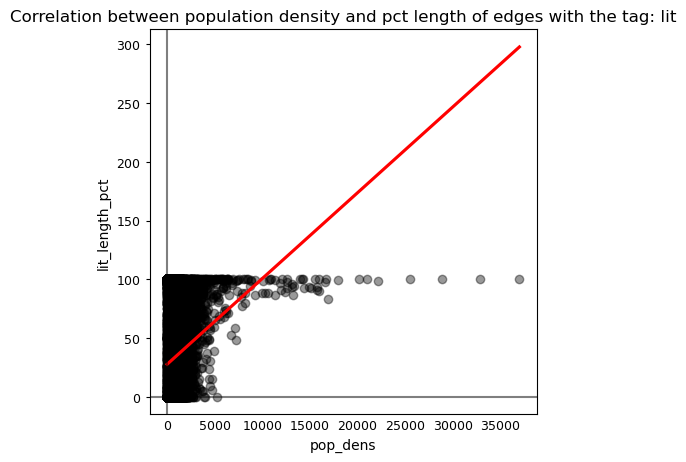

In [18]:
for i, v in enumerate(variable_names):
    f, ax = plt.subplots(1, figsize=(5, 5))

    sns.regplot(
        x="pop_dens",
        y=length_cols[i],
        ci=None,
        data=joined_grid,
        line_kws={"color": "r"},
        scatter_kws={"alpha": 0.4},
        color="black",
    )

    ax.axvline(0, c="k", alpha=0.5)
    ax.axhline(0, c="k", alpha=0.5)
    ax.set_title(
        f"Correlation between population density and pct length of edges with the tag: {v}"
    )
    plt.show()